In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import pandas as pd

sys.path.append('../../../param_search')
import param_search as ps

ps.set_verbose(False)
ps.set_backend('slurm')

In [3]:
csv_path = '2025-11-02_selected.csv'
sel = pd.read_csv(csv_path)
sel

,subject,metadata.category.set,metadata.category.len,metadata.category.set_f,metadata.category.len_f,metadata.category.valid,metadata.category.reasons,metadata.unit.value,metadata.unit.valid,metadata.unit.reasons,...,artifacts.valid,artifacts.reasons,valid,reasons,artifacts.scene.exc,paths.source_mask.exc,source_path,job_name,job_id,dims_error
0,wss.100f39dce7690f59efb94709f30ce0d2,"{'Recliner', 'Chair'}",2,"{'Recliner', 'Chair'}",2,True,(),0.012947,True,(),...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,7.294375e-08
1,wss.101354f9d8dede686f7b08d9de913afe,"{'Speaker', '_Attributes'}",2,{'Speaker'},1,True,(),0.013620,True,(),...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,1.319075e-08
2,wss.1029fd5d71a06ea32ea98d69e91ba870,{'ChestOfDrawers'},1,{'ChestOfDrawers'},1,True,(),0.019631,True,(),...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,8.319422e-08
3,wss.102a6b7809f4e51813842bc8ef6fe18,"{'Desktop', 'Computer'}",2,"{'Desktop', 'Computer'}",2,True,(),0.025252,True,(),...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,1.077898e-07
4,wss.107637b6bdf8129d4904d89e9169817b,{'Couch'},1,{'Couch'},1,True,(),0.022625,True,(),...,True,(),True,(),NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,0103f8f8d5c25bf7,35732758,7.520307e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,wss.d81f943065391492a7e760c0b399301,"{'FoodItem', 'Bowl', '_StanfordSceneDBModels',...",4,"{'FoodItem', 'Bowl', 'FruitBowl'}",3,True,(),0.001381,True,(),...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN
1112,wss.d8d4004791c4f61b80fa98b5eeb7036c,"{'_StanfordSceneDBModels', 'Book'}",2,{'Book'},1,True,(),0.000002,True,(),...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN
1113,wss.e8add7acb28e2505fd40810f48721e8b,"{'Bed', 'DoubleBed'}",2,"{'Bed', 'DoubleBed'}",2,True,(),0.009245,True,(),...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,5c023e2f832d4dcf,35732849,NaN
1114,wss.f6420a3a3addd027f67be63aca8832dd,"{'Recliner', 'Chair'}",2,"{'Recliner', 'Chair'}",2,True,(),0.027262,True,(),...,True,(),False,"('missing dims',)",NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,8786de37533664e5,35732850,NaN


In [103]:
base_dir = '2025-11-02_preprocess'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/preprocess.py --dataset shapenet --data_root $LP/data/ShapeNetSem --variant {variant} --config $NB/{config} --subject {subject}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-02', config='2025-11-02_config.json')
len(grid)

1116

In [6]:
# changes:
# - image generation with solid texture networks (same variant)
# - use cell data instead of node data for mesh scalars (labels + fields)
# - reduce material vote rate 1e-3 to 1e-4 for more variation

base_dir = '2025-11-05_preprocess'

template = '''\
#!/bin/bash -l
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -t 24:00:00
set -eo pipefail

LP=$PROJECT/lung-project
NB=$PROJECT/lung-project/notebooks/shapenet

mamba activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp

python $LP/preprocess.py --dataset shapenet --data_root $LP/data/ShapeNetSem --variant {variant} --config $NB/{config} --subject {subject}

'''
name_format = '{params_hash}'

grid = ps.param_grid(subject=sel.subject, variant='2025-11-02', config='2025-11-05_config.json')
len(grid)

1116

In [7]:
%autoreload
try:
    jobs = ps.setup(base_dir, template, name_format, grid, overwrite=False)
except OSError:
    jobs = ps.load(base_dir)

jobs

,job_name,job_state,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,...,params.variant,params.config,array_idx,last_live_at,state_source,finalized,finalized_at,output_exists,output_fsize,output_mtime
0,db2c4f1ec0622d3a,COMPLETED,1,35839869,w003,00:03:23,Skipping simulate_displacement_field: Output /...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2025-11-02,2025-11-05_config.json,NaN,2025-11-06T03:03:09,history,True,2025-11-06T03:08:52,False,None,None
1,e3d5069a003c0389,COMPLETED,1,35839870,w009,00:04:11,0 Background 0.000001 1000000.000000 ...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2025-11-02,2025-11-05_config.json,NaN,2025-11-06T03:03:09,history,True,2025-11-06T03:08:52,False,None,None
2,2bbb37117dbf41b9,COMPLETED,1,35839871,v034,00:02:08,Skipping simulate_displacement_field: Output /...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2025-11-02,2025-11-05_config.json,NaN,2025-11-06T03:08:52,history,True,2025-11-06T12:52:03,False,None,None
3,d32b82ea5f1dd332,COMPLETED,1,35839872,w003,00:02:16,2 DenseMedium 1.000000 0.333333 ...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2025-11-02,2025-11-05_config.json,NaN,2025-11-06T03:08:52,history,True,2025-11-06T12:52:03,False,None,None
4,7555bb1078b8b24a,COMPLETED,1,35839873,w009,00:00:35,Skipping simulate_displacement_field: Output /...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2025-11-02,2025-11-05_config.json,NaN,2025-11-06T03:08:52,history,True,2025-11-06T12:52:03,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,45faf486366d2316,COMPLETED,1,35840980,v013,00:02:05,0 Background 0.000001 1000000.000000 ...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2025-11-02,2025-11-05_config.json,NaN,2025-11-06T03:08:52,history,True,2025-11-06T12:52:03,False,None,None
1112,a1c698834094bd5b,COMPLETED,1,35840981,v021,00:01:36,Building material catalog\n material_key de...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2025-11-02,2025-11-05_config.json,NaN,2025-11-06T03:08:52,history,True,2025-11-06T12:52:03,False,None,None
1113,0c8e9e2dcb96e5a7,COMPLETED,1,35840982,v008,00:00:43,Skipping create_volume_mesh_from_mask: Output ...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2025-11-02,2025-11-05_config.json,NaN,2025-11-06T03:08:52,history,True,2025-11-06T12:52:03,False,None,None
1114,d2b1496eeed84c5c,COMPLETED,1,35840983,v008,00:00:43,Skipping create_volume_mesh_from_mask: Output ...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,/ocean/projects/asc170022p/mtragoza/lung-proje...,...,2025-11-02,2025-11-05_config.json,NaN,2025-11-06T03:08:52,history,True,2025-11-06T12:52:03,False,None,None


In [8]:
%autoreload
jobs = ps.recover(jobs)
jobs = ps.status(jobs)
jobs = ps.history(jobs)
jobs.groupby(['job_state']).count()

,job_name,n_submits,job_id,node_id,runtime,stdout,stderr,base_dir,work_dir,script_path,...,params.variant,params.config,array_idx,last_live_at,state_source,finalized,finalized_at,output_exists,output_fsize,output_mtime
job_state,,,,,,,,,,,,,,,,,,,,,
COMPLETED,1115,1115,1115,1115,1115,1115,1115,1115,1115,1115,...,1115,1115,0,1115,1115,1115,1115,1115,0,0
FAILED,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,0,0


In [ ]:
jobs = ps.collect(jobs)

In [9]:
# mark non-failed jobs to resubmit
jobs.loc[(jobs.job_state != 'FAILED'), 'job_id'] = pd.NA

In [10]:
%autoreload
jobs = ps.submit(jobs)

In [13]:
sys.path.append('../..')
import project
ds = project.datasets.shapenet.ShapeNetDataset(data_root='../../data/ShapeNetSem')
examples = ds.examples(sel.subject.tolist(), variant='2025-11-02', image_tag='solid_texture')

In [95]:
ex = next(examples)
ex

Example(dataset='ShapeNet', subject='wss.13b48456dad49f8762edbb9e1af21a03', variant='2025-11-02', paths={'source_mesh': PosixPath('../../data/ShapeNetSem/models-OBJ/models/13b48456dad49f8762edbb9e1af21a03.obj'), 'source_mask': PosixPath('../../data/ShapeNetSem/models-binvox-solid/13b48456dad49f8762edbb9e1af21a03.binvox'), 'surface_mesh': PosixPath('../../data/ShapeNetSem/2025-11-02/13b48456dad49f8762edbb9e1af21a03/meshes/surface.xdmf'), 'binary_mask': PosixPath('../../data/ShapeNetSem/2025-11-02/13b48456dad49f8762edbb9e1af21a03/masks/binary.nii.gz'), 'region_mask': PosixPath('../../data/ShapeNetSem/2025-11-02/13b48456dad49f8762edbb9e1af21a03/masks/regions.nii.gz'), 'volume_mesh': PosixPath('../../data/ShapeNetSem/2025-11-02/13b48456dad49f8762edbb9e1af21a03/meshes/volume.xdmf'), 'material_mask': PosixPath('../../data/ShapeNetSem/2025-11-02/13b48456dad49f8762edbb9e1af21a03/masks/material.nii.gz'), 'density_field': PosixPath('../../data/ShapeNetSem/2025-11-02/13b48456dad49f8762edbb9e1af21

Loading ../../data/ShapeNetSem/2025-11-02/13b48456dad49f8762edbb9e1af21a03/images/solid_texture.nii.gz
Loading ../../data/ShapeNetSem/2025-11-02/13b48456dad49f8762edbb9e1af21a03/fields/density.nii.gz
Loading ../../data/ShapeNetSem/2025-11-02/13b48456dad49f8762edbb9e1af21a03/fields/elasticity.nii.gz
(-0.1583326905965805, 1.6590211391448975)


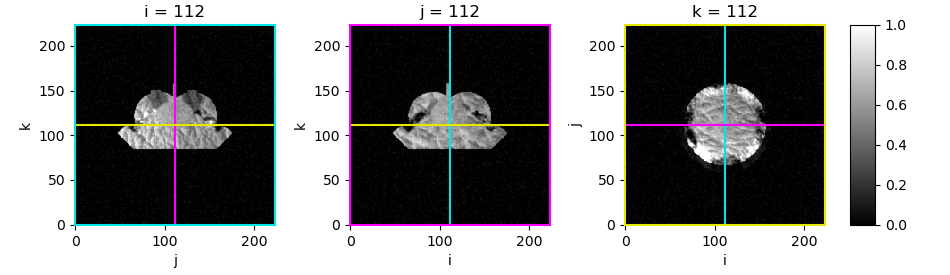

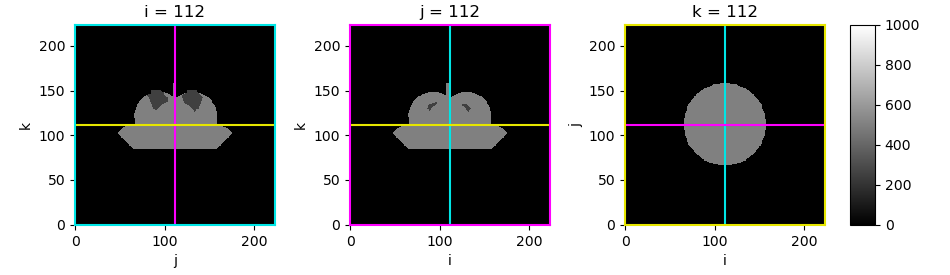

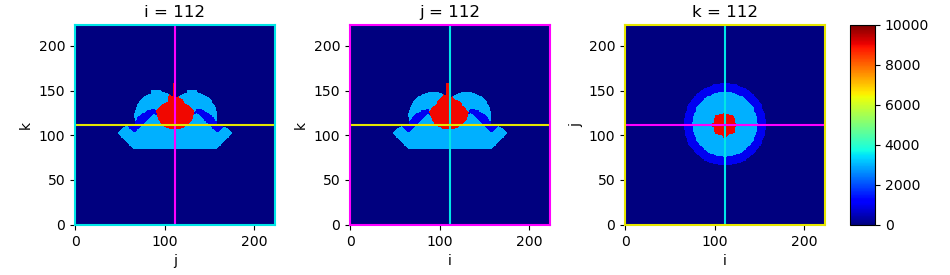

In [96]:
%matplotlib widget
import project.visual.matplotlib

image = project.core.fileio.load_nibabel(ex.paths['input_image']).get_fdata()
density = project.core.fileio.load_nibabel(ex.paths['density_field']).get_fdata()
elastic = project.core.fileio.load_nibabel(ex.paths['elastic_field']).get_fdata()

clim = (float(image.min()), float(image.max()))
print(clim)

_ = project.visual.matplotlib.show_image_slices(image, cmap='gray', clim=(0, 1), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(density, cmap='gray', clim=(0, 1000), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(elastic, cmap='jet',  clim=(0, 10000), colors='cmy')

array([0.   , 0.005, 0.02 , 0.045, 0.08 , 0.125, 0.18 , 0.245, 0.32 ,
       0.405, 0.5  , 0.595, 0.68 , 0.755, 0.82 , 0.875, 0.92 , 0.955,
       0.98 , 0.995, 1.   ])

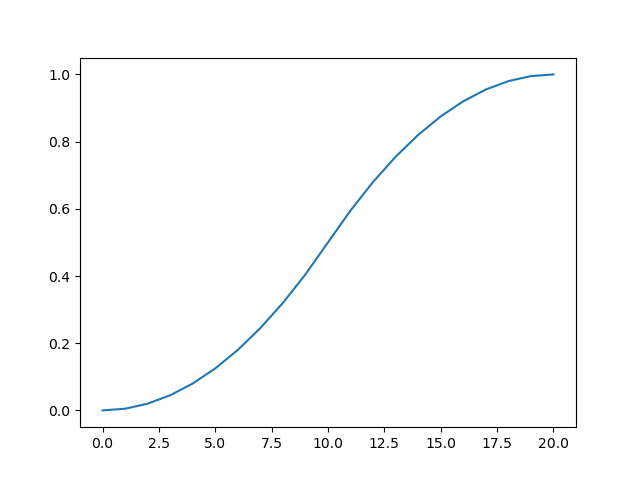

In [97]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

n = 11
x = np.arange(n)**2
x = (x + x.min()) / (x.max() - x.min()) / 2
x = np.concatenate([x, 1 - x[::-1][1::]])
ax.plot(x)
x

In [98]:
import project.visual.pyvista
image = project.core.fileio.load_nibabel(ex.paths['input_image']).get_fdata()
p = project.visual.pyvista.plot_volume(image, cmap='binary', clim=(0, 1), opacity=x)
p.show(jupyter_backend='trame')

Loading ../../data/ShapeNetSem/2025-11-02/13b48456dad49f8762edbb9e1af21a03/images/solid_texture.nii.gz


Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14b6d36ef190_12" src="https://ondemand.bridges2.…